# 09 — Less Variables (Improved)

This notebook is a cleaned, faster and more reproducible copy of `09_Less_Variables_XGBoost.ipynb`.
It adds a small `Parameters` cell, a reusable training helper, and a `QUICK` mode for fast iteration.

In [1]:
# Parameters — change these to run experiments
from pathlib import Path
ROOT = Path('.').resolve()
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")
Output_PATH = Path("/Users/nikola/Python/KaggleCompetition/output/10_output")
SEED = 42
QUICK = True           # set to False to run full pipeline (temporary set True for quick run)
SAMPLE_FRAC = 0.15      # used only when QUICK=True
N_SPLITS = 3 if QUICK else 5
TEST_MONTHS = 3 if QUICK else 6
N_ESTIMATORS = 200 if QUICK else 800
EARLY_STOPPING_ROUNDS = 25 if QUICK else 50
RANDOM_STATE = SEED
TARGET_COL = 'amount_new_house_transactions'




In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.max_columns', 200)
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Load only the minimal data files used in the original notebook
print('DATA_PATH:', DATA_PATH)
new_house = pd.read_csv(DATA_PATH / 'train' / 'new_house_transactions.csv', parse_dates=['month'])
pre_owned = pd.read_csv(DATA_PATH / 'train' / 'pre_owned_house_transactions.csv', parse_dates=['month'])
new_house_nearby = pd.read_csv(DATA_PATH / 'train' / 'new_house_transactions_nearby_sectors.csv', parse_dates=['month'])

print('Loaded shapes:')
print(' new_house', new_house.shape)
print(' pre_owned', pre_owned.shape)
print(' new_house_nearby', new_house_nearby.shape)

# Quick sample to speed up iterations
if QUICK:
    new_house = new_house.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).sort_values(['sector','month']).reset_index(drop=True)
    pre_owned = pre_owned[pre_owned['sector'].isin(new_house['sector'].unique())]
    new_house_nearby = new_house_nearby[new_house_nearby['sector'].isin(new_house['sector'].unique())]
    print('QUICK mode ON — sampled new shapes: ', new_house.shape, pre_owned.shape, new_house_nearby.shape)

DATA_PATH: /Users/nikola/Python/KaggleCompetition/data
Loaded shapes:
 new_house (5433, 11)
 pre_owned (5360, 6)
 new_house_nearby (5360, 11)
QUICK mode ON — sampled new shapes:  (815, 11) (5293, 6) (5293, 11)


In [4]:
# Create a minimal master dataset and perform conservative feature engineering
df = new_house.copy()
# minimal merges (month, sector)
cols_pre = [c for c in ['month','sector','amount_pre_owned_house_transactions','price_pre_owned_house_transactions'] if c in pre_owned.columns]
cols_near = [c for c in ['month','sector','amount_new_house_transactions_nearby_sectors'] if c in new_house_nearby.columns]
df = df.merge(pre_owned[cols_pre], on=['month','sector'], how='left')
df = df.merge(new_house_nearby[cols_near], on=['month','sector'], how='left')

# Basic time features
df['month_num'] = df['month'].dt.month
df['year'] = df['month'].dt.year
df['is_december'] = (df['month'].dt.month == 12).astype(int)
df['is_february'] = (df['month'].dt.month == 2).astype(int)

# Ratio feature if both prices exist
if 'price_pre_owned_house_transactions' in df.columns and 'price_new_house_transactions' in df.columns:
    df['new_to_preowned_price_ratio'] = df['price_new_house_transactions'] / df['price_pre_owned_house_transactions'].replace(0, np.nan)

# Sort and add lagged features in a leakage-safe way
df = df.sort_values(['sector','month']).reset_index(drop=True)
lag_features = [col for col in ['num_new_house_available_for_sale','amount_pre_owned_house_transactions','period_new_house_sell_through'] if col in df.columns]
for f in lag_features:
    df[f + '_lag1'] = df.groupby('sector')[f].shift(1)

# Sector expanding historical features (shifted to avoid leakage)
df['sector_historical_mean'] = df.groupby('sector')[TARGET_COL].transform(lambda x: x.expanding().mean().shift(1))
df['sector_historical_std'] = df.groupby('sector')[TARGET_COL].transform(lambda x: x.expanding().std().shift(1))
df['months_since_start'] = df.groupby('sector').cumcount()

# Save a processed copy for reproducibility (overwrites previous)
proc_path = DATA_PATH / 'processed_data_improved.csv'
df.to_csv(proc_path, index=False)
print('Processed data saved to:', proc_path)
print('Final df shape:', df.shape)

Processed data saved to: /Users/nikola/Python/KaggleCompetition/data/processed_data_improved.csv
Final df shape: (815, 25)


In [5]:
# --- Minimal Missing Values Analysis (adapted from notebook 09)
print('--- MISSING VALUES ANALYSIS (minimal) ---')
datasets = {}
# collect datasets we have available (non-breaking)
if 'new_house' in globals(): datasets['new_house'] = new_house
if 'pre_owned' in globals(): datasets['pre_owned'] = pre_owned
if 'new_house_nearby' in globals(): datasets['new_house_nearby'] = new_house_nearby
for name, d in datasets.items():
    print(f"\n{name.upper()}: " )
    print('-'*40)
    any_missing = False
    for col in d.columns:
        missing_count = int(d[col].isnull().sum())
        if missing_count > 0:
            any_missing = True
            missing_pct = missing_count / len(d) * 100
            print(f"{col}: {missing_count} ({missing_pct:.2f}%)")
    if not any_missing:
        print('No missing values')

--- MISSING VALUES ANALYSIS (minimal) ---

NEW_HOUSE: 
----------------------------------------
num_new_house_available_for_sale: 2 (0.25%)
area_new_house_available_for_sale: 2 (0.25%)
period_new_house_sell_through: 2 (0.25%)

PRE_OWNED: 
----------------------------------------
price_pre_owned_house_transactions: 14 (0.26%)

NEW_HOUSE_NEARBY: 
----------------------------------------
No missing values


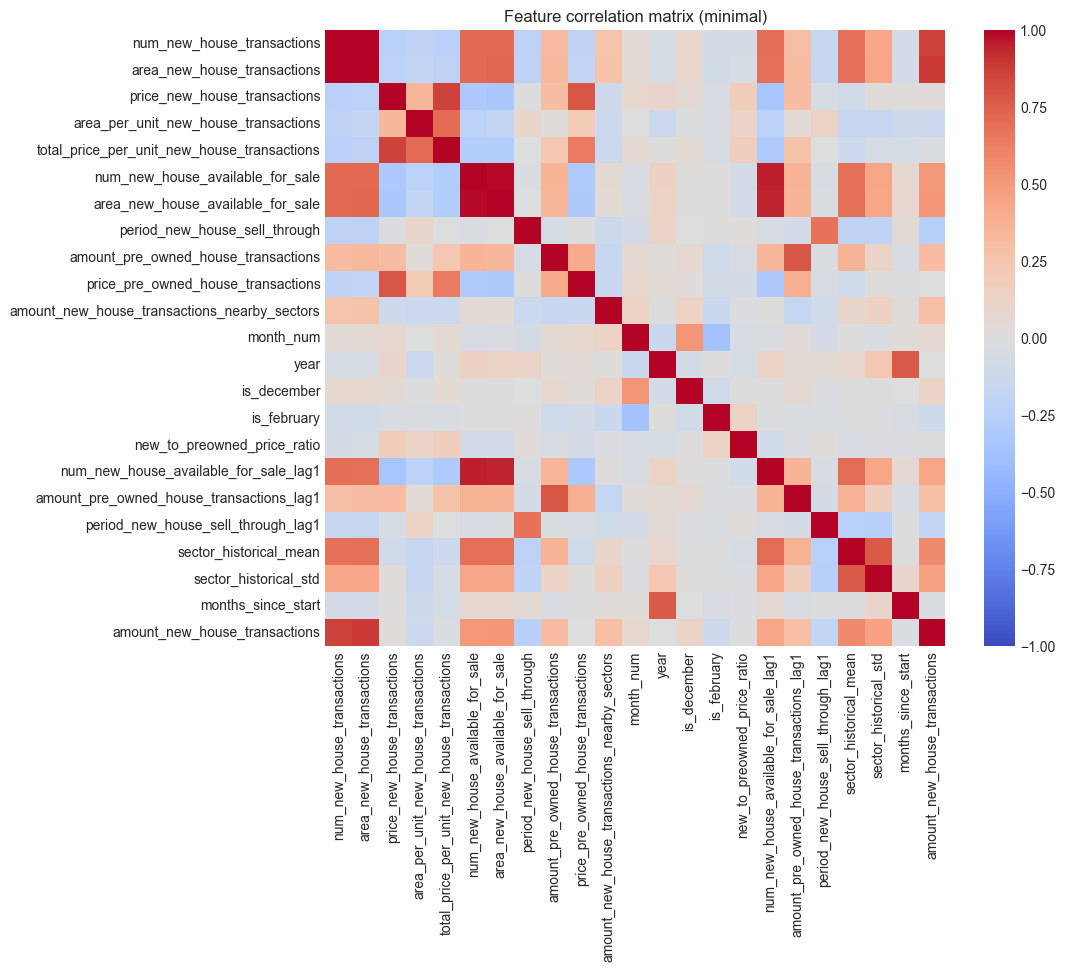


High-correlation pairs (>= 0.85):
num_new_house_transactions vs area_new_house_transactions: 0.994
num_new_house_available_for_sale vs area_new_house_available_for_sale: 0.989
num_new_house_available_for_sale vs num_new_house_available_for_sale_lag1: 0.952
area_new_house_available_for_sale vs num_new_house_available_for_sale_lag1: 0.944
price_new_house_transactions vs total_price_per_unit_new_house_transactions: 0.852


In [6]:
# --- Minimal Correlation Analysis (heatmap + high-corr pairs) ---
try:
    import seaborn as sns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if TARGET_COL in numeric_cols:
        numeric_cols.remove(TARGET_COL)
    if len(numeric_cols) > 0:
        corr = df[numeric_cols + [TARGET_COL]].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, center=0, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Feature correlation matrix (minimal)')
        plt.show()
        # Find high-correlation pairs among numeric features
        feat_corr = df[numeric_cols].corr().abs()
        high_pairs = []
        threshold = 0.85
        for i in range(len(feat_corr.columns)):
            for j in range(i+1, len(feat_corr.columns)):
                v = feat_corr.iloc[i,j]
                if v >= threshold:
                    high_pairs.append((feat_corr.columns[i], feat_corr.columns[j], v))
        if high_pairs:
            print('\nHigh-correlation pairs (>= {:.2f}):'.format(threshold))
            for a,b,v in sorted(high_pairs, key=lambda x: -x[2]):
                print(f'{a} vs {b}: {v:.3f}')
        else:
            print('\nNo high-correlation pairs found (threshold={:.2f})'.format(threshold))
    else:
        print('No numeric features available for correlation analysis')
except Exception as e:
    print('Skipping correlation analysis (error):', e)

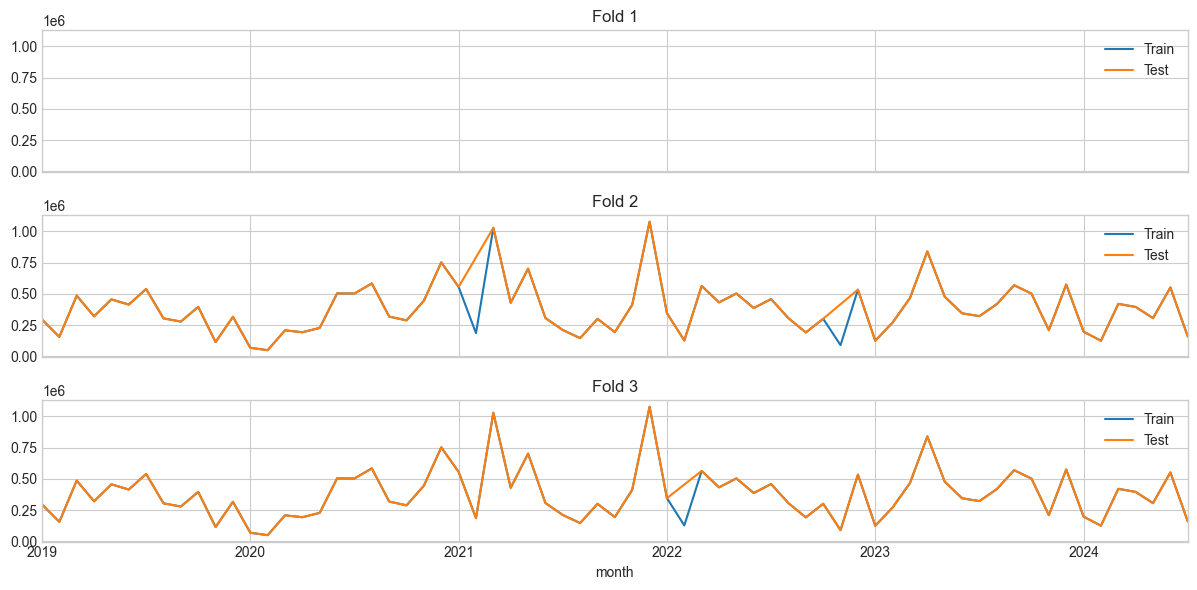

In [7]:
# --- Visualize TimeSeriesSplit (minimal) ---
try:
    monthly_target = df.groupby('month')[TARGET_COL].sum().sort_index()
    tscv_viz = TimeSeriesSplit(n_splits=N_SPLITS)
    fig, axes = plt.subplots(N_SPLITS, 1, figsize=(12, max(3, 2*N_SPLITS)), sharex=True)
    for idx, (train_idx, test_idx) in enumerate(tscv_viz.split(df)):
        train_months = df.iloc[train_idx]['month'].unique()
        test_months = df.iloc[test_idx]['month'].unique()
        train_data = monthly_target[monthly_target.index.isin(train_months)]
        test_data = monthly_target[monthly_target.index.isin(test_months)]
        ax = axes[idx] if N_SPLITS > 1 else axes
        train_data.plot(ax=ax, label='Train', color='#1f77b4')
        test_data.plot(ax=ax, label='Test', color='#ff7f0e')
        ax.set_title(f'Fold {idx+1}')
        ax.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Skipping CV-split visualization (error):', e)

In [8]:
# Custom competition score (same logic as original)
def custom_competition_score(y_true, y_pred):
    ape = np.abs((y_pred - y_true) / y_true)
    extreme_errors = np.sum(ape > 1.0) / len(ape)
    if extreme_errors > 0.3:
        return 0.0
    valid_mask = ape <= 1.0
    if np.sum(valid_mask) == 0:
        return 0.0
    mape_valid = np.mean(ape[valid_mask])
    fraction_valid = np.sum(valid_mask) / len(ape)
    scaled_mape = mape_valid / fraction_valid
    score = 1 - scaled_mape
    return max(0, score)

In [9]:
# Reusable training helper (TimeSeriesSplit + XGBoost)
def train_cv(df, feature_cols, target_col, n_splits=3, test_months=3, xgb_params=None, early_stopping=25):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    mask = ~y.isna()
    X = X[mask]
    y = y[mask]

    # Build TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    models = []
    scores = []
    preds = []

    for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(**(xgb_params or {}))

        # Fit with early stopping in a compatibility-safe way:
        # 1) try the common early_stopping_rounds argument
        # 2) fallback to callbacks-based early stopping
        # 3) final fallback: plain fit without early stopping
        try:
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=early_stopping,
                verbose=False,
            )
        except TypeError:
            try:
                callbacks = [xgb.callback.EarlyStopping(rounds=early_stopping, save_best=True)]
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    callbacks=callbacks,
                    verbose=False,
                )
            except Exception:
                # Last-resort: fit without early stopping
                model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

        y_pred = model.predict(X_test)
        score = custom_competition_score(y_test.values, y_pred)

        models.append(model)
        scores.append(score)
        preds.append((test_idx, y_pred))

        print(f'Fold {i+1} — comp_score: {score:.4f} — rows train={len(X_train)} test={len(X_test)}')

    return {'models': models, 'scores': scores, 'preds': preds}

In [10]:
# Prepare features and run training
non_features = ['month','date','sector', TARGET_COL] if 'date' in df.columns else ['month','sector', TARGET_COL]
feature_cols = [c for c in df.columns if c not in non_features]
print('Using features:', len(feature_cols))

xgb_params = {
    'n_estimators': N_ESTIMATORS,
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'verbosity': 0,
    'objective': 'reg:squarederror'
}

res = train_cv(df, feature_cols, TARGET_COL, n_splits=N_SPLITS, xgb_params=xgb_params, early_stopping=EARLY_STOPPING_ROUNDS)
print(f"Average competition score: {np.mean(res['scores']):.4f}")

Using features: 22
Fold 1 — comp_score: 0.7697 — rows train=206 test=203
Fold 2 — comp_score: 0.7651 — rows train=409 test=203
Fold 3 — comp_score: 0.8460 — rows train=612 test=203
Average competition score: 0.7936
Fold 2 — comp_score: 0.7651 — rows train=409 test=203
Fold 3 — comp_score: 0.8460 — rows train=612 test=203
Average competition score: 0.7936


Top features (name, score):
[('area_new_house_transactions', np.float32(0.22358422)), ('num_new_house_transactions', np.float32(0.09765843)), ('sector_historical_mean', np.float32(0.09093883)), ('period_new_house_sell_through', np.float32(0.07642421)), ('sector_historical_std', np.float32(0.07225688)), ('new_to_preowned_price_ratio', np.float32(0.0681954)), ('total_price_per_unit_new_house_transactions', np.float32(0.06261194)), ('num_new_house_available_for_sale_lag1', np.float32(0.05709053)), ('price_new_house_transactions', np.float32(0.038159218)), ('month_num', np.float32(0.036864568)), ('price_pre_owned_house_transactions', np.float32(0.03557371)), ('num_new_house_available_for_sale', np.float32(0.033451386)), ('amount_new_house_transactions_nearby_sectors', np.float32(0.01914977)), ('is_february', np.float32(0.016276708)), ('year', np.float32(0.014433946)), ('area_per_unit_new_house_transactions', np.float32(0.013839628)), ('amount_pre_owned_house_transactions', np.float32(0.012

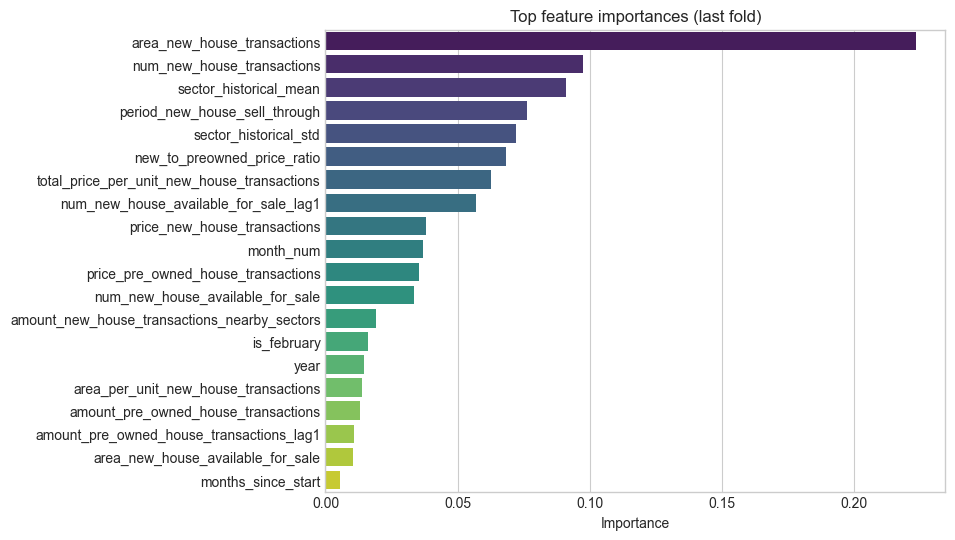

In [11]:
# Quick evaluation of results and feature importance (last model)
models = res['models']
scores = res['scores']
last_model = models[-1] if len(models) > 0 else None

if last_model is not None:
    importances = last_model.feature_importances_
    idx = np.argsort(importances)[::-1][:20]
    top_feats = [(feature_cols[i], importances[i]) for i in idx]
    print('Top features (name, score):')
    print(top_feats)
    plt.figure(figsize=(8,6))
    sns.barplot(x=[v for (_,v) in top_feats], y=[n for (n,_) in top_feats], palette='viridis')
    plt.title('Top feature importances (last fold)')
    plt.xlabel('Importance')
    plt.show()
else:
    print('No trained model found — run the training cell first.')

In [12]:
# Final training on all available historical data and simple submission flow
full_train_mask = df[TARGET_COL].notna()
X_full = df.loc[full_train_mask, feature_cols].dropna()
y_full = df.loc[X_full.index, TARGET_COL]
print('Training final model on', len(X_full), 'rows')
final_params = xgb_params.copy()
final_params.update({'n_estimators': 800 if not QUICK else 200})
final_model = xgb.XGBRegressor(**final_params)
final_model.fit(X_full, y_full, verbose=False)

# Prepare a simple submission: use the sample submission to get months/sectors
sample_sub = pd.read_csv(DATA_PATH / 'sample_submission.csv')
sample_sub['year'] = sample_sub['id'].str.split(' ').str[0].astype(int)
sample_sub['month_abbr'] = sample_sub['id'].str.split('_').str[0].str.split(' ').str[1]
sample_sub['sector'] = sample_sub['id'].str.split('_').str[1]
sample_sub['month'] = pd.to_datetime(sample_sub['year'].astype(str) + ' ' + sample_sub['month_abbr'], format='%Y %b')
future_rows = sample_sub[['month','sector']].copy()
# Merge last known values (conservative)
last_vals = df.groupby('sector')[lag_features].last().reset_index() if len(lag_features)>0 else None
if last_vals is not None:
    future_rows = future_rows.merge(last_vals, on='sector', how='left')

# Fill na with training medians
for c in feature_cols:
    if c in future_rows.columns:
        future_rows[c] = future_rows[c].fillna(X_full[c].median() if c in X_full.columns else 0)

# Ensure X_sub has all columns that were in X_full, filling missing ones with the median
for col in X_full.columns:
    if col not in future_rows.columns:
        future_rows[col] = X_full[col].median()  # Use median from training data
X_sub = future_rows[X_full.columns] # Use the same columns order as X_full
preds = final_model.predict(X_sub)
preds = np.maximum(preds, 0)
sample_sub['amount'] = preds
out_path = Output_PATH / 'submission_improved.csv'
sample_sub[['id','amount']].to_csv(out_path, index=False)
print('Wrote submission to', out_path)

Training final model on 556 rows
Wrote submission to /Users/nikola/Python/KaggleCompetition/output/10_output/submission_improved.csv


## Quick visualization of final submission_improved.csv

This cell loads the generated `submission_improved.csv` (or falls back to `output/submission_improved.csv`), parses the `id` into month and sector, and plots:
1. Monthly total predicted amounts (time series).
2. Top 10 sectors by total predicted amount (bar chart).

The visualization is defensive — if the CSV is missing or columns differ it will print a helpful message instead of erroring.

In [16]:
# Visualize final submission_improved.csv (monthly totals + top sectors)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

candidates = [
    Output_PATH / 'submission_improved.csv',
    Path('output') / 'submission_improved.csv',
    Path('output') / 'submissions' / 'submission_improved.csv',
    DATA_PATH / 'submission_improved.csv',
    DATA_PATH / 'submission.csv'
]
found = None
for p in candidates:
    if p is None:
        continue
    try:
        if Path(p).exists():
            found = Path(p)
            break
    except Exception:
        continue
if found is None:
    print('Could not find submission_improved.csv in expected locations.')
Looked in:', candidates)
else:
    print('Loading submission from', found)
    sub = pd.read_csv(found)
    # try to extract month & sector from common id formats — fallback to sample_sub when available
    if 'month' not in sub.columns or 'sector' not in sub.columns:
        if 'id' in sub.columns:
            # id format examples seen in repo: '2025 Jan_sectorName' or '2025 Jan_sector' or similar
            def parse_id(i):
                try:
                    parts = str(i).split('_')
                    # month part may have a space like '2025 Jan' or be combined
                    if len(parts) >= 2:
                        month_part = parts[0]
                        sector_part = '_'.join(parts[1:])
                    else:
                        # fallback split on space
                        sp = str(i).split(' ')
                        month_part = ' '.join(sp[:2]) if len(sp) >= 2 else sp[0]
                        sector_part = '_'.join(sp[2:]) if len(sp) > 2 else ''
                    # try parse month_part into a datetime month (year + month abbr)
                    try:
                        ts = pd.to_datetime(month_part, format='%Y %b')
                    except Exception:
                        # try only month name (no year)
                        try:
                            ts = pd.to_datetime(month_part)
                        except Exception:
                            ts = pd.NaT
                    return pd.Series({'month': ts, 'sector': sector_part})
                except Exception:
                    return pd.Series({'month': pd.NaT, 'sector': ''})
            parsed = sub['id'].apply(parse_id)
            sub = pd.concat([sub, parsed], axis=1)
    # Ensure month is datetime and drop rows missing month
    if 'month' in sub.columns:
        try:
            sub['month'] = pd.to_datetime(sub['month'])
        except Exception:
            pass
    # Aggregate monthly totals
    if 'month' in sub.columns:
        monthly = sub.groupby('month')['amount'].sum().sort_index()
        plt.figure(figsize=(12,5))
        monthly.plot(marker='o')
        plt.title('Predicted monthly totals (submission_improved)')
        plt.ylabel('Total amount')
        plt.xlabel('Month')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print('Month column not available; cannot plot monthly totals')
    # Top sectors
    if 'sector' in sub.columns and sub['sector'].notna().sum() > 0:
        top = sub.groupby('sector')['amount'].sum().nlargest(10)
        plt.figure(figsize=(10,6))
        sns.barplot(x=top.values, y=top.index, palette='magma')
        plt.title('Top 10 sectors by predicted total')
        plt.xlabel('Total predicted amount')
        plt.ylabel('Sector')
        plt.show()
    else:
        print('Sector information not found in submission file')

SyntaxError: unterminated string literal (detected at line 27) (2224414435.py, line 27)

In [17]:
# --- Minimal Zero Prediction Analysis (adapted from notebook 09) ---
try:
    predictions = preds if isinstance(preds, (list, np.ndarray)) else np.array(sample_sub['amount'])
    # Ensure numpy array
    predictions = np.array(predictions)
    zero_mask = predictions == 0
    num_zeros = int(np.sum(zero_mask))
    print(f'Total zero predictions: {num_zeros}/{len(predictions)} ({100*num_zeros/len(predictions):.1f}%)')
    if num_zeros > 0:
        zero_rows = sample_sub[zero_mask] if len(sample_sub)==len(predictions) else None
        if zero_rows is not None:
            print('Sectors with zero predictions:')
            print(zero_rows['sector'].value_counts().head(10))
        # show some feature stats if X_sub exists
        if 'X_sub' in globals():
            X_sub_zeros = X_sub[zero_mask] if len(X_sub)==len(predictions) else None
            if X_sub_zeros is not None:
                print('Feature stats for zero-pred rows (first 5):')
                print(X_sub_zeros.describe().head())
    else:
        print('✓ No zero predictions found')
except Exception as e:
    print('Skipping zero-prediction analysis (error):', e)

Total zero predictions: 0/1152 (0.0%)
✓ No zero predictions found
